# Data access patterns

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import pickle
import sys

df_orig = pd.read_pickle("/data/cms/scratch/jvilalta/Notebooks_ML/df_final_xCache.pkl")

## Consecutive interval time gaps

Average percentile 85: 14.15
Average percentile 70: 5.58
Average percentile 65: 3.85


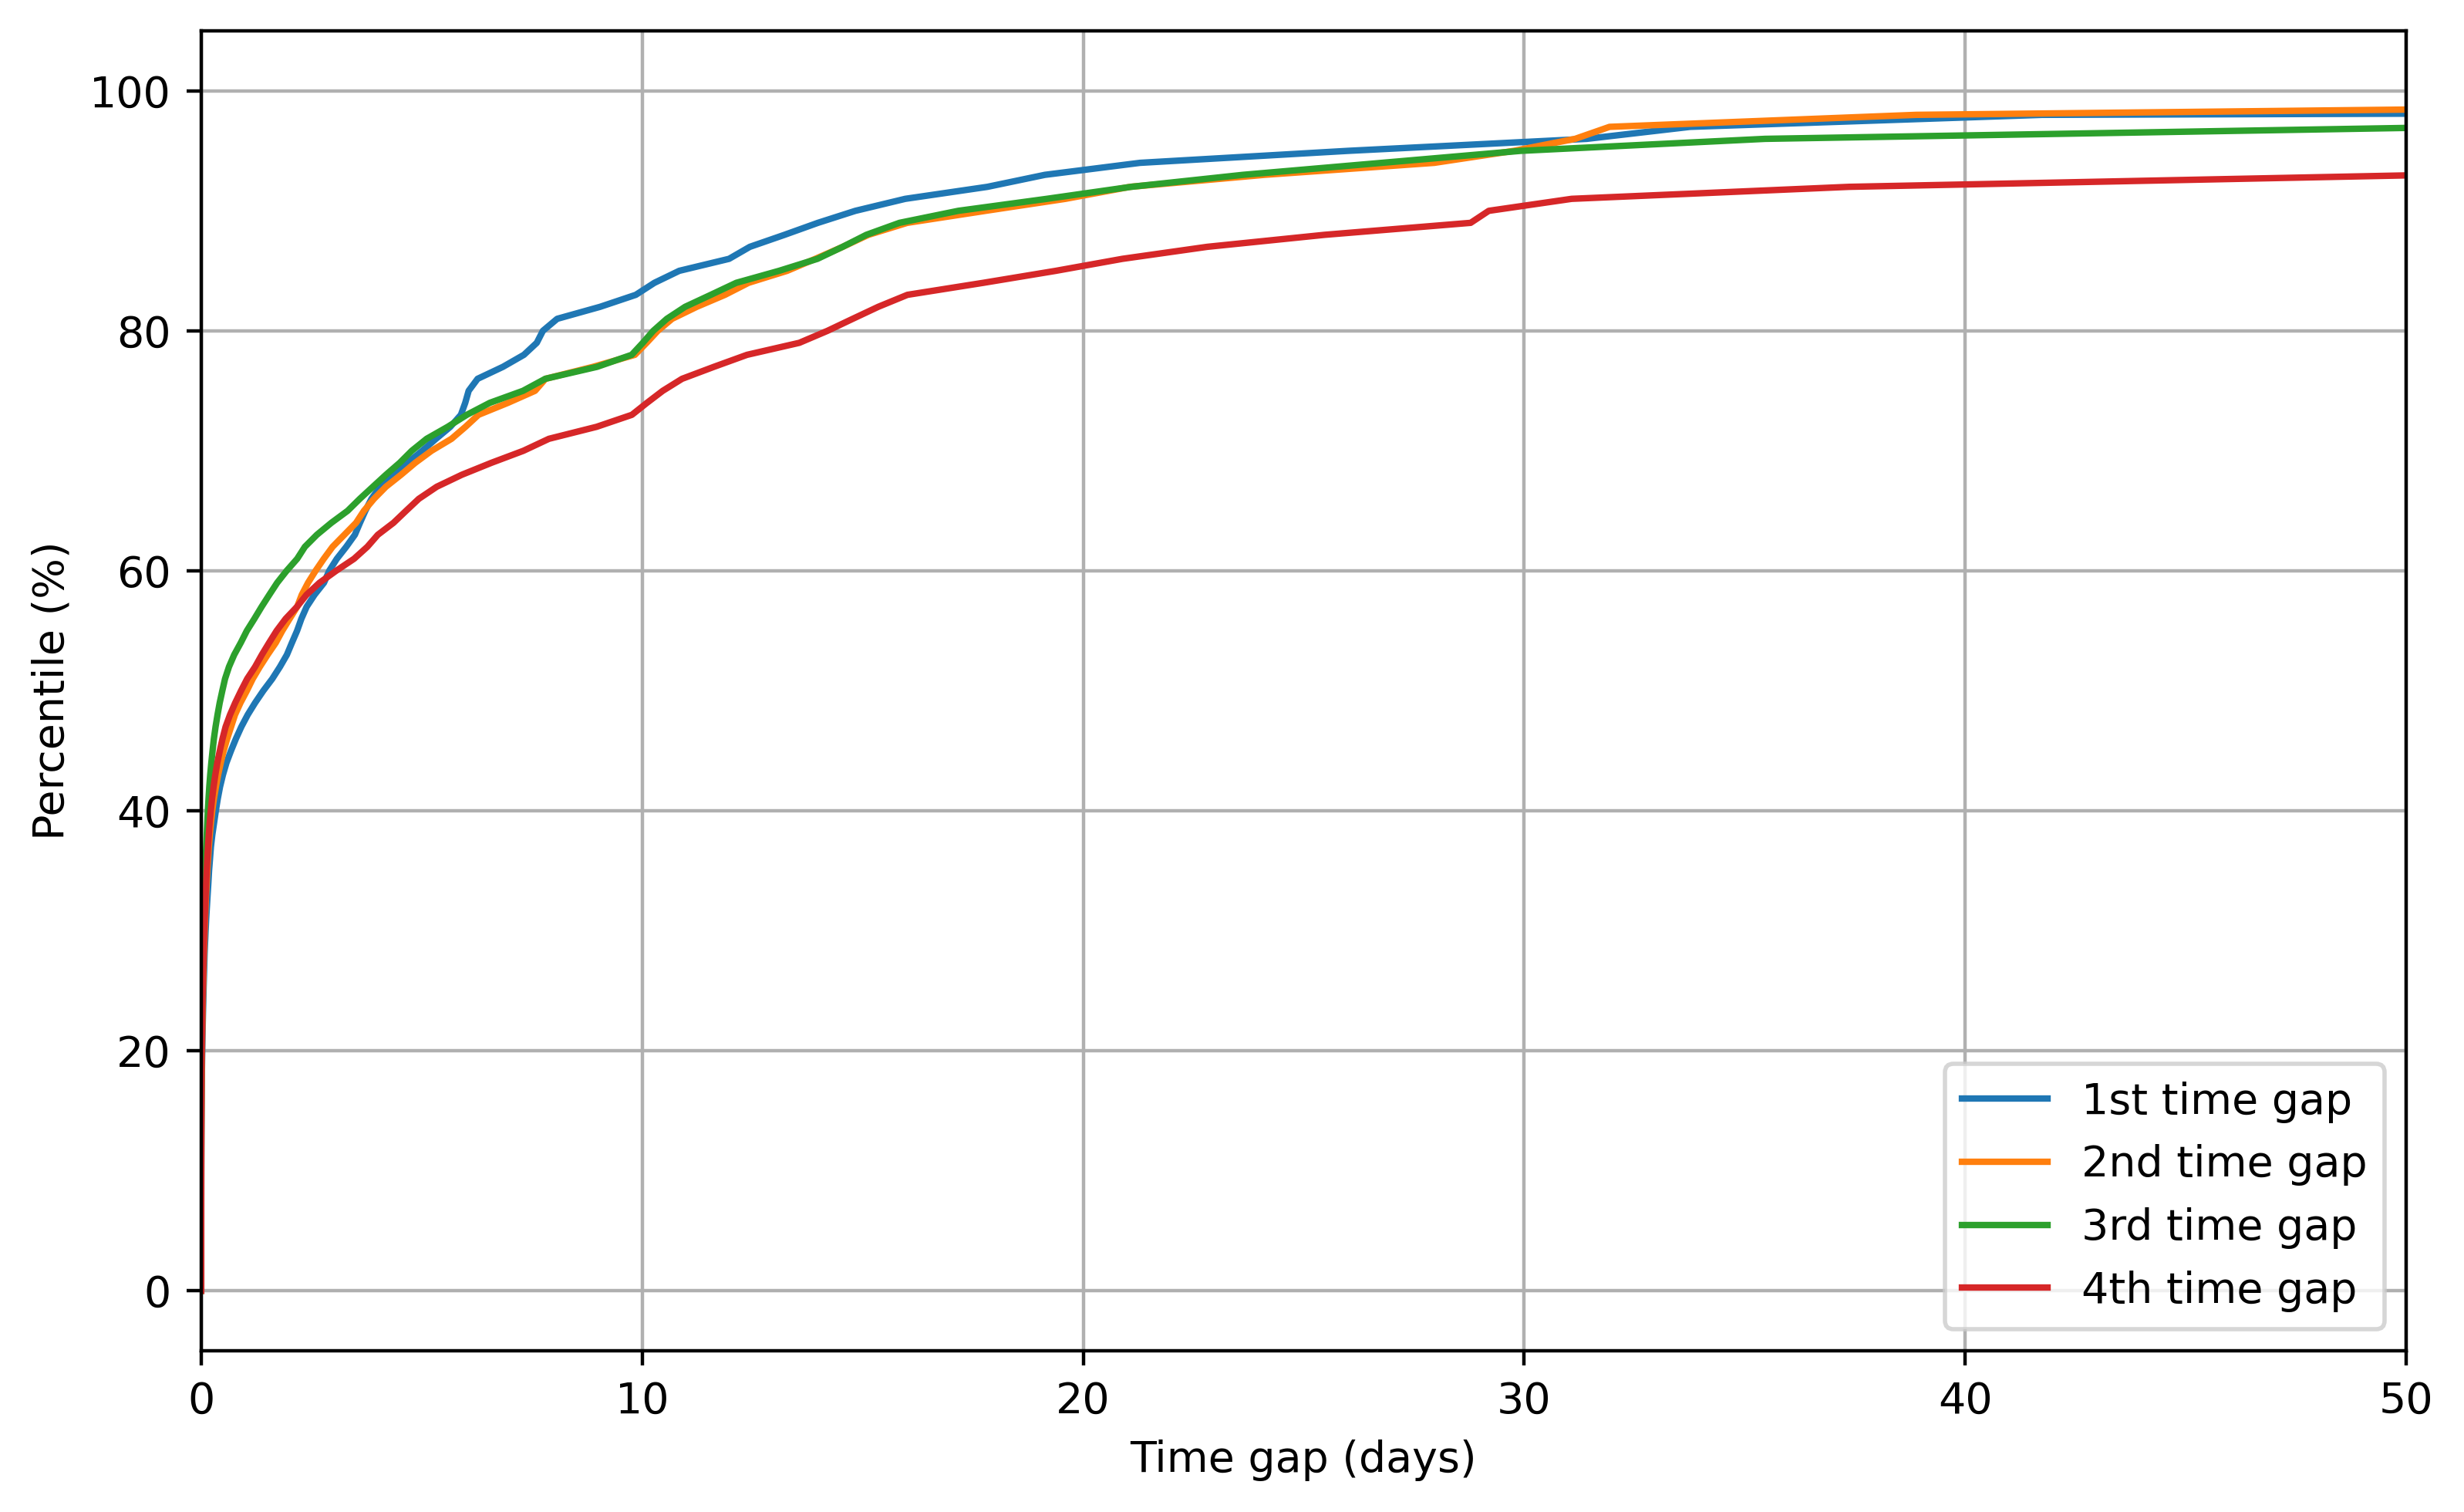

In [2]:
df = df_orig.copy()

deltaT_ij = {}

df.sort_values(['filename', 'time'], ascending=[True, True], inplace = True)

df["time5"] = df['time']
df["time4"] = df['time'].shift(-1)
df["time3"] = df['time'].shift(-2)
df["time2"] = df['time'].shift(-3)
df["time1"] = df['time'].shift(-4)

df.loc[df['Total Accesses (full)'] == 1, 'time4'] = np.nan
df.loc[df['Total Accesses (full)'] == 1, 'time3'] = np.nan
df.loc[df['Total Accesses (full)'] == 1, 'time2'] = np.nan
df.loc[df['Total Accesses (full)'] == 1, 'time1'] = np.nan
    
df.loc[df['Total Accesses (full)'] == 2, 'time3'] = np.nan
df.loc[df['Total Accesses (full)'] == 2, 'time2'] = np.nan
df.loc[df['Total Accesses (full)'] == 2, 'time1'] = np.nan
    
df.loc[df['Total Accesses (full)'] == 3, 'time2'] = np.nan
df.loc[df['Total Accesses (full)'] == 3, 'time1'] = np.nan
    
df.loc[df['Total Accesses (full)'] == 4, 'time1'] = np.nan

df.sort_values(['filename', 'time'], ascending=[True, True], inplace = True)
df.drop_duplicates(subset = ['filename'], keep = 'first', inplace = True)

df['4th_delta_ij'] = (df['time1'] - df['time2'])/(60*60*24)
df['3rd_delta_ij'] = (df['time2'] - df['time3'])/(60*60*24)
df['2nd_delta_ij'] = (df['time3'] - df['time4'])/(60*60*24)
df['1st_delta_ij'] = (df['time4'] - df['time5'])/(60*60*24)

df = df[df['Total Accesses (full)'] > 4].copy()

deltaT_ij = {
    '1st time gap': df['1st_delta_ij'].to_numpy(),
    '2nd time gap': df['2nd_delta_ij'].to_numpy(),
    '3rd time gap': df['3rd_delta_ij'].to_numpy(),
    '4th time gap': df['4th_delta_ij'].to_numpy(),
}

for key in deltaT_ij:
    deltaT_ij[key] = deltaT_ij[key][~np.isnan(deltaT_ij[key])]

p = np.linspace(0,100,101)

deltas = {}
for key in deltaT_ij.keys():
    deltas[key] = []
    for i in p:
        deltas[key].append(np.percentile(deltaT_ij[key], i))

percentile_85 = []
percentile_70 = []
percentile_65 = []
for key in deltaT_ij.keys():
    percentile_85.append(np.percentile(deltaT_ij[key], 85))
    percentile_70.append(np.percentile(deltaT_ij[key], 70))
    percentile_65.append(np.percentile(deltaT_ij[key], 65))

print(f"Average percentile 85: {np.mean(percentile_85):.2f}")
print(f"Average percentile 70: {np.mean(percentile_70):.2f}")
print(f"Average percentile 65: {np.mean(percentile_65):.2f}")

plt.figure(figsize=(8,5), dpi = 400)
for key in deltas.keys():
    plt.plot(deltas[key], p, label = key)
plt.ylabel('Percentile (%)')
plt.xlabel('Time gap (days)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid()
plt.xlim(0,50)
plt.savefig("./figures/acces_gaps.png")
plt.show()

## Prediction gaps

In [3]:
start_date = datetime(2023, 6, 1)

def generate_periods(start_date, periods, days_per_period):
    result = []
    
    for _ in range(periods):
        end_date = start_date + timedelta(days=days_per_period)
        period_str = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
        result.append(period_str)
        start_date = end_date
    
    return result

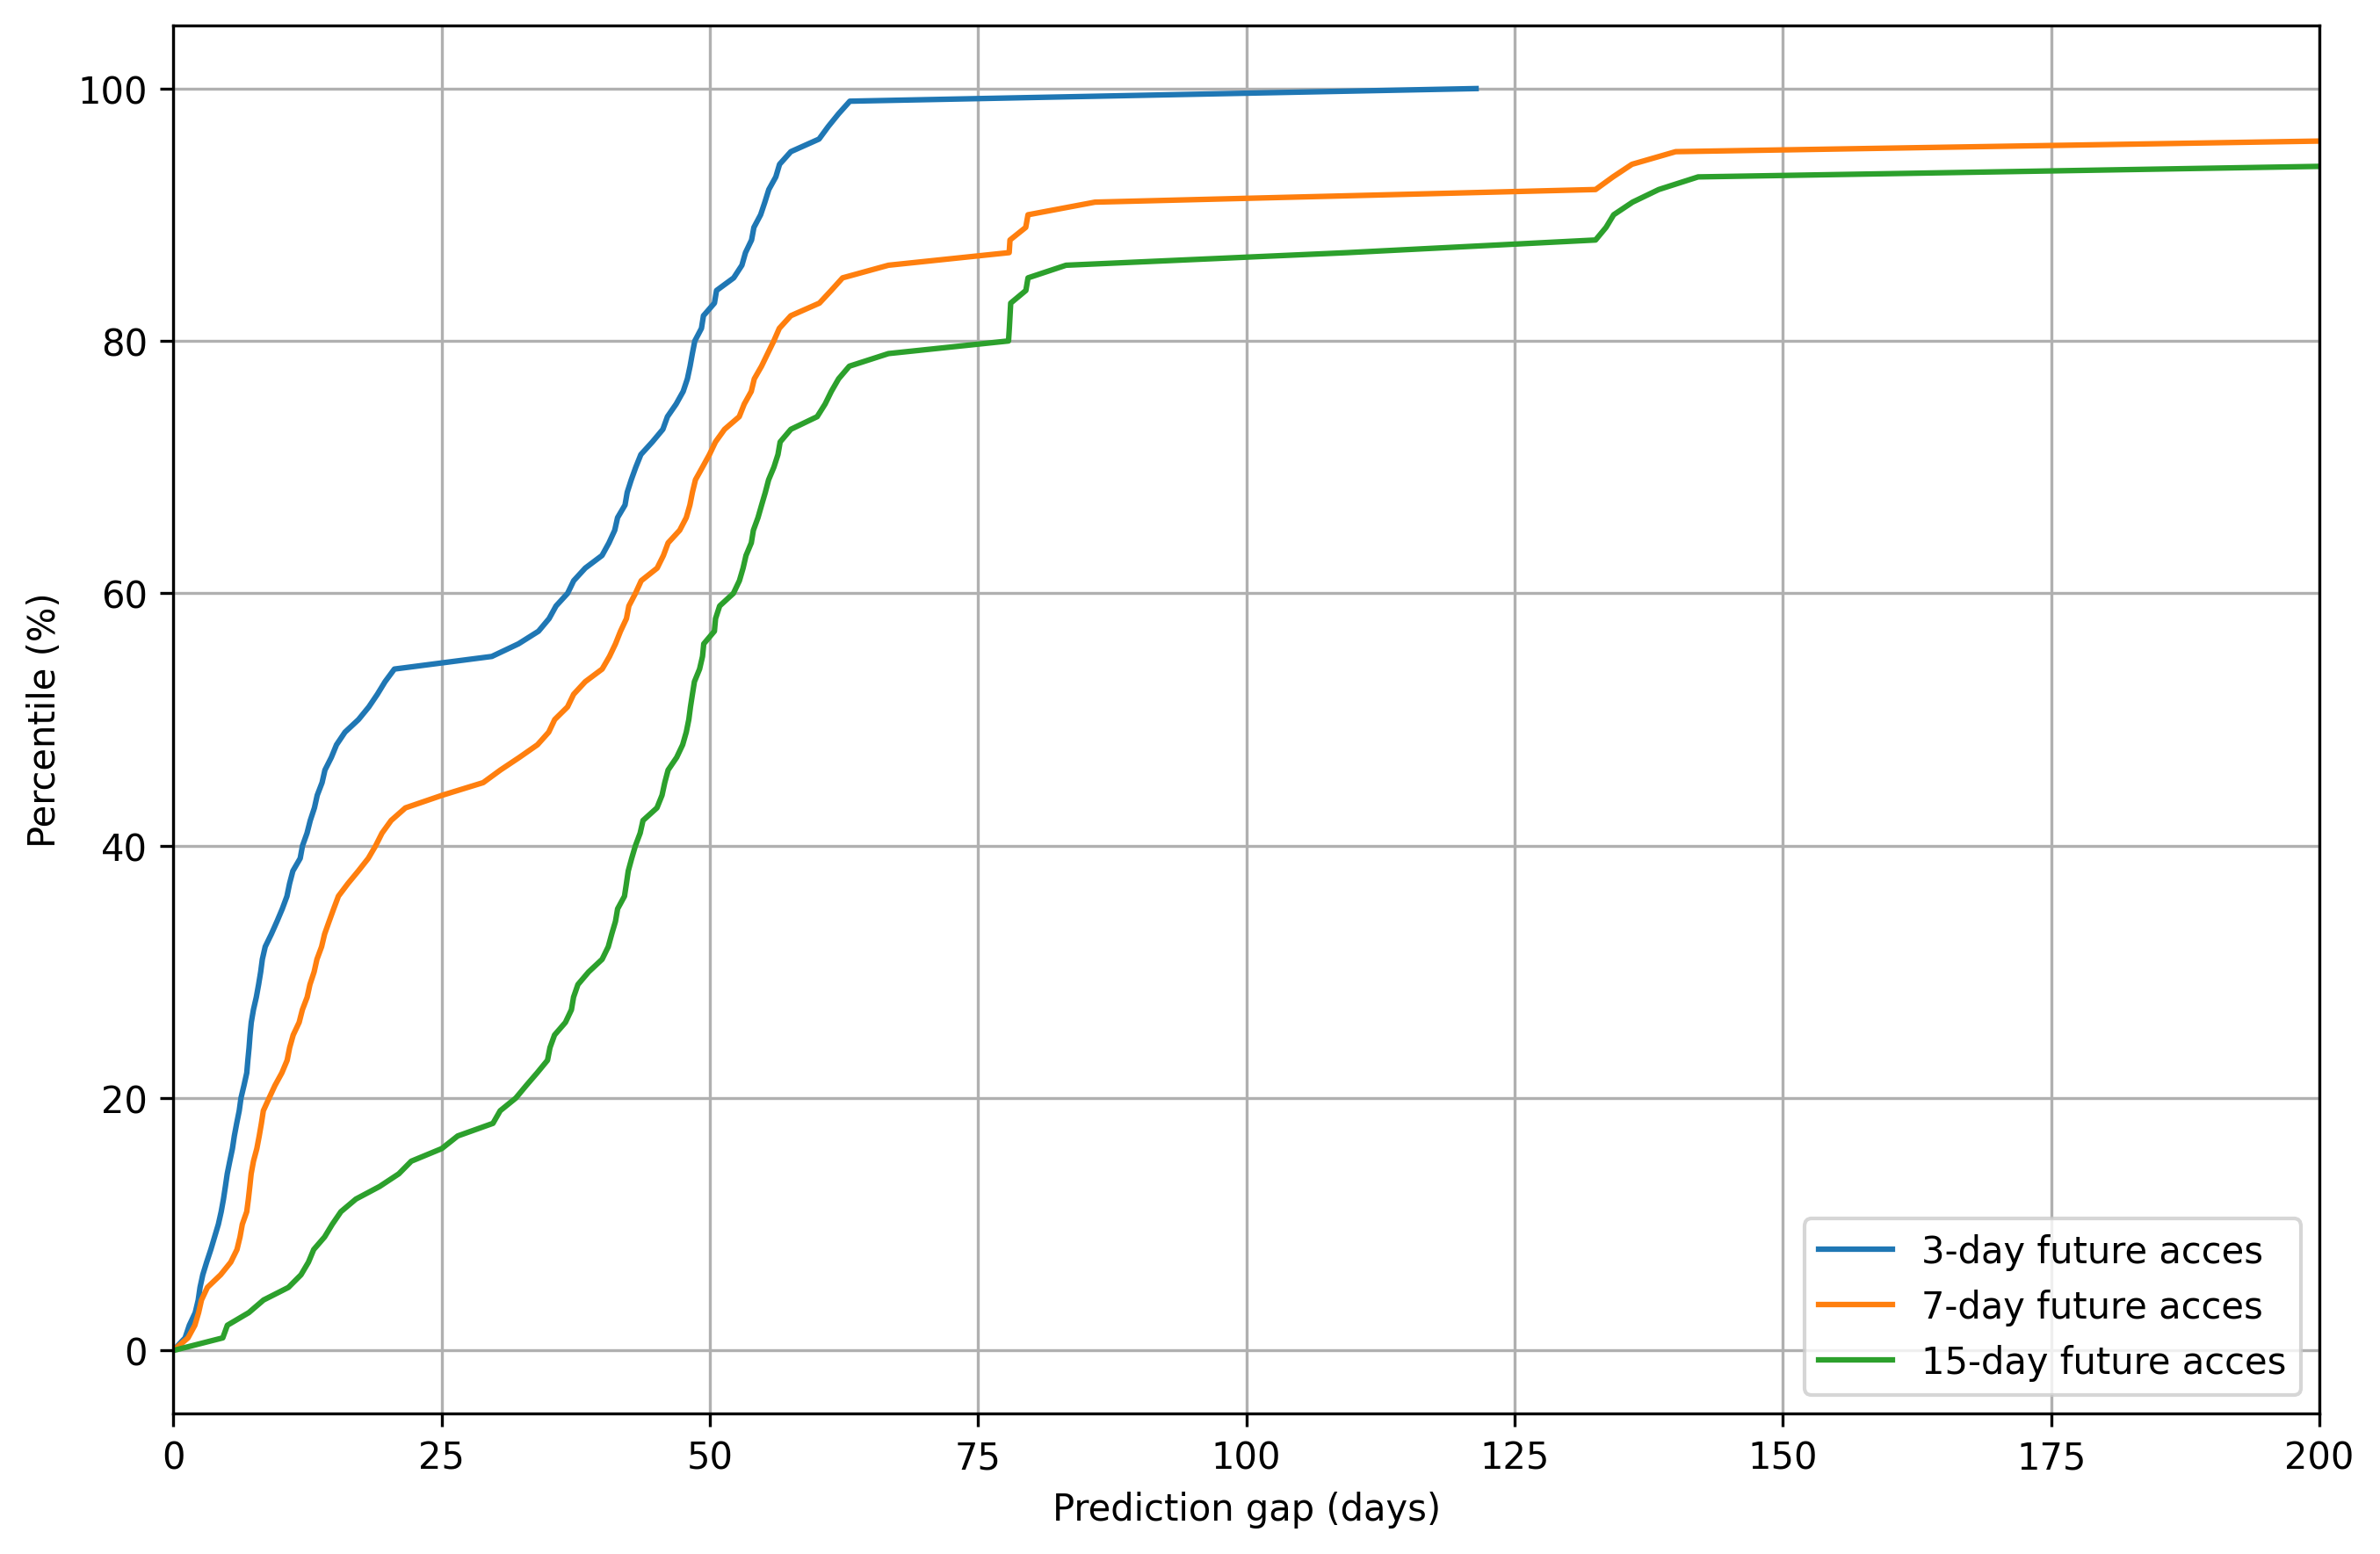

In [4]:
df = df_orig.copy()


# ---------3-day future access---------
periods = generate_periods(start_date, 47, 3)

p = periods[0][0]
m = periods[1][1]

train_p = []
fut_acc_p = []

for i in range(0,len(periods)-2):
    train_p.append([periods[i][0], periods[i+1][1]])
    fut_acc_p.append([periods[i+1][1], periods[i+2][1]])


three_day_fut_acc = []

for rl in range(0,len(train_p)):
    
    df1 = df[(df['date'] < train_p[rl][1])].copy()
    df2 = df[ (df['date'] >= fut_acc_p[rl][0]) & (df['date']< fut_acc_p[rl][1])].copy()

    df_merged = df1.merge(df2[['filename', 'time']], on='filename', how='left' , suffixes=('_train', '_future'))

    df_merged = df_merged.dropna()

    df_merged['Prediction gap'] = (df_merged['time_future'] - df_merged['time_train']) / (60 * 60 * 24) 

    df_merged['Prediction gap'].tolist()
    
    three_day_fut_acc.extend(df_merged['Prediction gap'].tolist())


# ---------7-day future access---------
periods = generate_periods(start_date, 47, 7)

p = periods[0][0]
m = periods[1][1]

train_p = []
fut_acc_p = []

for i in range(0,len(periods)-2):
    train_p.append([periods[i][0], periods[i+1][1]])
    fut_acc_p.append([periods[i+1][1], periods[i+2][1]])



seven_day_fut_acc = []

for rl in range(0,len(train_p)):
    
    df1 = df[(df['date'] < train_p[rl][1])].copy()
    df2 = df[ (df['date'] >= fut_acc_p[rl][0]) & (df['date']< fut_acc_p[rl][1])].copy()

    df_merged = df1.merge(df2[['filename', 'time']], on='filename', how='left' , suffixes=('_train', '_future'))

    df_merged = df_merged.dropna()

    df_merged['Prediction gap'] = (df_merged['time_future'] - df_merged['time_train']) / (60 * 60 * 24) 

    df_merged['Prediction gap'].tolist()
    
    seven_day_fut_acc.extend(df_merged['Prediction gap'].tolist())


# ---------15-day future access---------
periods = generate_periods(start_date, 47, 15)

p = periods[0][0]
m = periods[1][1]

train_p = []
fut_acc_p = []

for i in range(0,len(periods)-2):
    train_p.append([periods[i][0], periods[i+1][1]])
    fut_acc_p.append([periods[i+1][1], periods[i+2][1]])



fifteen_day_fut_acc = []

for rl in range(0,len(train_p)):
    
    df1 = df[(df['date'] < train_p[rl][1])].copy()
    df2 = df[ (df['date'] >= fut_acc_p[rl][0]) & (df['date']< fut_acc_p[rl][1])].copy()

    df_merged = df1.merge(df2[['filename', 'time']], on='filename', how='left' , suffixes=('_train', '_future'))

    df_merged = df_merged.dropna()

    df_merged['Prediction gap'] = (df_merged['time_future'] - df_merged['time_train']) / (60 * 60 * 24) 

    df_merged['Prediction gap'].tolist()
    
    fifteen_day_fut_acc.extend(df_merged['Prediction gap'].tolist())


####################
p = np.linspace(0,100,101)

three_percentile = []
seven_percentile = []
fifteen_percentile = []

for i in p:
    three_percentile.append(np.percentile(three_day_fut_acc, i))
    seven_percentile.append(np.percentile(seven_day_fut_acc, i))
    fifteen_percentile.append(np.percentile(fifteen_day_fut_acc, i))

plt.figure(figsize=(9,6), dpi = 300)
plt.plot(three_percentile, p, label = '3-day future acces')
plt.plot(seven_percentile, p, label = '7-day future acces')
plt.plot(fifteen_percentile, p, label = '15-day future acces')
plt.ylabel('Percentile (%)')
plt.xlabel('Prediction gap (days)')
plt.grid()
plt.tight_layout()
plt.legend(loc = 'lower right')
plt.savefig("./figures/prediction_gap.png")
plt.xlim(0,200)
plt.show()